In [13]:
# Import all modules
import PyPDF2
import pandas as pd
import os
from re import search

In [14]:
# Returns a list of whatever is inside the directory(in local machine) 
pdf_list = os.listdir('.')

# Ignore list, since I had this notebook in my local machine, stored in the same directory
remove_list = ['.DS_Store','.ipynb_checkpoints','paycheck_analyzer.ipynb','.git','.gitignore','README.md']

# Removes items in the ignore list
pdf_list = [i for i in pdf_list if i not in remove_list]

In [15]:
def read_paystub(stub):
    '''Function to extract regular hours, overtime hours, check date and pay period 
       input:  Mandarin Oriental Paystub in PDF format
       output: Python Dictionary of :
                hours, overtime, check date and pay period worked '''
    
    # Read the first page of paystub
    file = PyPDF2.PdfFileReader(stub) # feed the paycheck to PdfFileReader
    page1 = file.getPage(0).extractText() # Needed info is found in 1st page

    # Extract the check date
    date = page1[page1.find('Basis'):page1.find(' to')].strip()  
    date = date[11:-5]

    # Extract the pay period
    pperiod = page1[page1.find('Basis'):page1.find(' XXXX')].strip()
    pperiod = pperiod[21:38]

    # Extract the regular hours, overtime hours, vacation, sick, personal, retro 
    parsed = page1[page1.find('REGULAR'):page1.find('Total Earnings')].strip()

    # Split up the resulting extracted string to a list
    parsed_list = parsed.split(' ')

    def sick_holiday_hrs(parsed_list):
        '''A function that assigns 0 to the second item in the list, 
        if no overtime worked. Cleans up the first item in the list as regular hours.

        input: list of extracted paycheck info
        output: list of regular and overtime hours'''

        parsed_list[0] = parsed_list[0][7:12]
        parsed_list[1] = str(0)
        parsed_list = parsed_list[0:1]
        return parsed_list

    if search("HOLIDAY", parsed_list[1]):
        sick_holiday_hrs(parsed_list)
    elif search('SICK', parsed_list[1]):
        sick_holiday_hrs(parsed_list)
    elif search('VACATION', parsed_list[1]):
        sick_holiday_hrs(parsed_list)
    elif search('PERSONAL', parsed_list[1]):
        sick_holiday_hrs(parsed_list)
    elif search('RETRO', parsed_list[1]):
        sick_holiday_hrs(parsed_list)      
    else:
        parsed_list[0] = parsed_list[0][7:12]
        parsed_list[1] = parsed_list[1][8:12]
        parsed_list = parsed_list[0:2]

    # If the list contains "," a comma, this means that NO OT, then it will assign 0.
    # Restricts the list into two elements only.
    parsed_list = [ 0  if "," in x else x for x in parsed_list][:2] 

    # Convert the list to float
    parsed_list = list(map(float,parsed_list))

    # Additional check. I do not usually work 20 hours overtime, so for any reason 
    # overtime is more than 20, there must be a parsing error, 
    # then I'll reset the OT to 0
    if parsed_list[1] > 20:
        parsed_list[1] = 0

    # Construct the dictionary of date, pay period, hours and overtime hours
    hr_ot_dict = {'date': date, 'pperiod': pperiod, 'hours':parsed_list[0], 'ot':parsed_list[1] }

    # Return the dictionary
    return hr_ot_dict

In [16]:
results = list(map(read_paystub,pdf_list))

In [17]:
df = pd.DataFrame(results)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

In [18]:
def mask_year(year):
    mask = df['date'].dt.year == int(year)
    include = df[mask]
    exclude = df[~mask]
    return include

In [19]:
def mask_month(month):
    mask = df['date'].dt.month == month
    include = df[mask]
    exclude = df[~mask]
    return include

In [20]:
# My hourly rate multiply by time and a half(OT rate)

# Hourly Rate
hourly17 = 20.67
hourly18 = 22.41
hourly19 = 23.0823
hourly20 = 23.54
hourly21 = 24.2462

# OT Rate
rate17 = hourly17 * 1.5
rate18 = hourly18  * 1.5
rate19 = hourly19  * 1.5
rate20 = hourly20  * 1.5
rate21 = hourly21  * 1.5        

In [21]:
# Calculate overtime hours and rate 
def cal_ot(year,rate):
    ot = round(mask_year(year).ot.sum(),2)        
    return print(ot, 'hours', '$',"{0:,.2f}".format(round(ot * rate,2)))  

In [22]:
# Calculate regular hours and rate 
def cal_reg(year,rate):
    reg = round(mask_year(year).hours.sum(),2)
    return print(reg, 'hours', '$',"{0:,.2f}".format(round(reg * rate,2))) 

In [23]:
# select all rows with overtime
select_ot = lambda year: mask_year(year)[mask_year(year).ot > 0]

In [24]:
# visualize overtime per pay period
def bar_ot(year):
    sot = select_ot(year)
    return sot.groupby('pperiod').ot.sum().plot(kind='barh', figsize=(14,12));

## Regular Hours

### Started on September 2017

In [27]:
cal_reg(2017,hourly17) 

531.0 hours $ 10,975.77


### Full Year 2018

In [28]:
cal_reg(2018,hourly18) 

1944.25 hours $ 43,570.64


### Full Year 2019

In [29]:
cal_reg(2019,hourly19) 

1873.75 hours $ 43,250.46


### Partial Year 2020

In [30]:
cal_reg(2020,hourly20) 

1198.75 hours $ 28,218.58


### Partial Year 2021

In [31]:
cal_reg(2021,hourly21) 

850.0 hours $ 20,609.27


## Overtime Hours

### Started on September 2017

In [32]:
cal_ot(2017,rate17) 

110.85 hours $ 3,436.90


### Full Year 2018

In [33]:
cal_ot(2018,rate18)

321.55 hours $ 10,808.90


### Full Year 2019

In [34]:
cal_ot(2019,rate19)

173.9 hours $ 6,021.02


### Partial Year 2020

In [35]:
cal_ot(2020,rate20)

21.0 hours $ 741.51


### Partial Year 2021

In [36]:
cal_ot(2021,rate21)

35.25 hours $ 1,282.02


### Average Overtime per Month

In [37]:
df17 = mask_year(2017)
ot_17 = df17.groupby(df17['date'].dt.month).ot.mean()
# ot_17

In [38]:
df18 = mask_year(2018)
ot_18 = df18.groupby(df18['date'].dt.month).ot.mean()
# ot_18

In [39]:
ot_17 = ot_17.to_frame()
ot_18 = ot_18.to_frame()

In [40]:
combined1 = ot_17.merge(ot_18, on='date', how='outer')
combined1.columns = ['2017', '2018']

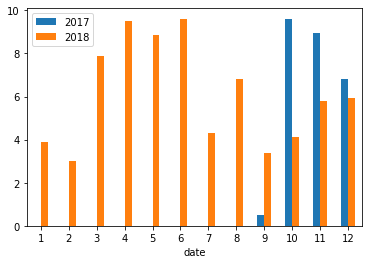

In [41]:
combined1.sort_index().plot(kind='bar', rot=0);

In [42]:
df19 = mask_year(2019)
ot_19 = df19.groupby(df19['date'].dt.month).ot.mean()
# ot_19

In [43]:
df20 = mask_year(2020)
ot_20 = df20.groupby(df20['date'].dt.month).ot.mean()
# ot_20

In [44]:
df21 = mask_year(2021)
ot_21 = df21.groupby(df21['date'].dt.month).ot.mean()
# ot_21

In [45]:
ot_19 = ot_19.to_frame()
ot_20 = ot_20.to_frame()

In [46]:
combined2 = ot_19.merge(ot_20, on='date', how='outer')
combined2.columns = ['2019', '2020']

In [47]:
combined2 = combined2.sort_index()

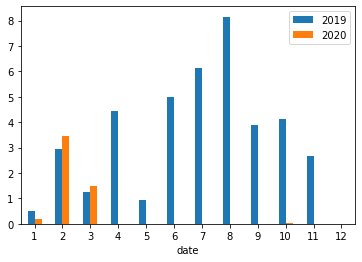

In [48]:
combined2.plot(kind='bar', rot=0);

In [49]:
ot_21 = ot_21.to_frame()

In [50]:
ot_21.columns = ['2021']

In [51]:
combined3 = combined1.merge(combined2, on='date', how='outer')

In [52]:
combined4 = combined3.merge(ot_21, on='date', how='outer')

In [53]:
combined4.sort_index()

,2017,2018,2019,2020,2021
date,,,,,
1,NaN,3.8750,0.5000,0.2000,0.000000
2,NaN,3.0000,2.9375,3.4375,0.000000
3,NaN,7.8900,1.2500,1.5000,0.000000
4,NaN,9.5000,4.4375,0.0000,0.400000
5,NaN,8.8400,0.9500,NaN,4.625000
6,NaN,9.6000,5.0000,NaN,4.916667
7,NaN,4.3125,6.1250,NaN,NaN
8,NaN,6.8300,8.1500,0.0000,NaN
9,0.5000,3.3750,3.8750,0.0000,NaN


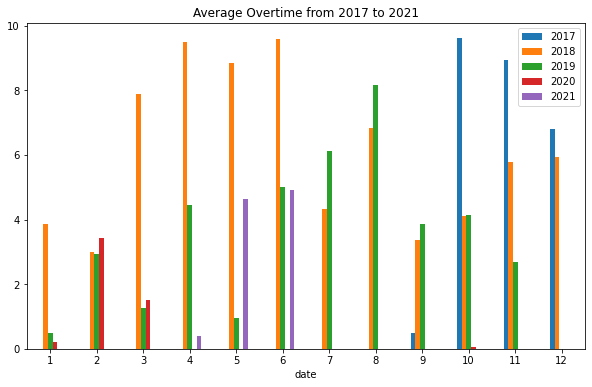

In [54]:
ax = combined4.sort_index().plot(kind='bar', rot=0, figsize=(10,6))
ax.set_title('Average Overtime from 2017 to 2021');